In [1]:
import pandas as pd
import warnings
import xarray as xr
import ephem
from datetime import datetime, timedelta
import math
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
station = '41043'
fname = 'https://www.ndbc.noaa.gov/data/realtime2/'+station+'.txt'
#more info: https://www.ndbc.noaa.gov/station_page.php?station=41043. 10 min intervals

In [3]:
df_buoy = pd.read_csv(fname, delim_whitespace=True, header=0, parse_dates=True,na_values='MM')
#delete units row
df_buoy = df_buoy.drop(index=0)


In [4]:
df_buoy.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
1,2024,09,25,01,00,100,3.0,4.0,NaN,NaN,NaN,NaN,1015.1,29.5,31.1,25.8,NaN,+1.7,NaN
2,2024,09,25,00,50,100,3.0,4.0,1.2,10,8.6,43,1015.0,29.6,NaN,25.8,NaN,NaN,NaN
3,2024,09,25,00,40,90,3.0,3.0,1.2,NaN,8.6,43,1015.0,29.6,31.0,25.4,NaN,NaN,NaN
4,2024,09,25,00,30,90,2.0,3.0,NaN,NaN,NaN,NaN,1014.8,29.5,30.9,25.5,NaN,NaN,NaN
5,2024,09,25,00,20,100,2.0,3.0,1.0,10,8.3,22,1014.5,29.6,NaN,25.6,NaN,NaN,NaN


In [5]:

# Rename columns to match expected input for to_datetime
df_buoy.rename(columns={"#YY": "year", "MM": "month", "DD": "day", "hh": "hour", "mm": "minute"}, inplace=True)

# Combine the date and time columns into a single timestamp
df_buoy['Timestamp'] = pd.to_datetime(df_buoy[['year', 'month', 'day', 'hour', 'minute']])

df_clean_buoy = df_buoy.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'DPD', 'MWD', 'PRES', 'DEWP', 'VIS', 'PTDY', 'TIDE']).drop(index=1)

In [6]:
df_clean_buoy.dtypes

WDIR                 object
WSPD                 object
GST                  object
WVHT                 object
APD                  object
ATMP                 object
WTMP                 object
Timestamp    datetime64[ns]
dtype: object

In [7]:
#reverse the data
df_reversed_clean_buoy = df_clean_buoy.iloc[::-1].reset_index(drop=True)
df_last_1800 = df_reversed_clean_buoy.tail(1800).copy()

columns_to_convert = ['WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP']

# Convert specified columns to float, using 'coerce' to handle errors
df_last_1800[columns_to_convert] = df_last_1800[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_last_1800 = df_last_1800.reset_index(drop=True)
df_last_1800 = df_last_1800.interpolate(method='linear', limit_direction='both')
df_last_1800.head()

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp
0,100.0,8.0,9.0,1.4,5.000000,28.2,29.3,2024-09-12 11:10:00
1,110.0,8.0,9.0,1.4,5.000000,28.1,29.3,2024-09-12 11:20:00
2,100.0,8.0,10.0,1.4,4.933333,27.9,29.3,2024-09-12 11:30:00
3,100.0,9.0,11.0,1.4,4.866667,27.7,29.3,2024-09-12 11:40:00
4,110.0,8.0,11.0,1.4,4.800000,27.2,29.3,2024-09-12 11:50:00


In [8]:
df_last_1800.shape

(1800, 8)

In [9]:
# Function to calculate sunlight for each timestamp
def calculate_sunlight(lat, lon, timestamps):
    # Initialize observer
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)

    # Initialize the Sun object
    sun = ephem.Sun()

    # Store results
    sunlight_data = []

    for timestamp in timestamps:
        observer.date = timestamp

        # Compute the position of the sun for the observer at the given time
        sun.compute(observer)

        # Altitude is in degrees (-90 to 90), where 90 is zenith and 0 is on the horizon
        altitude = sun.alt

        # Normalize sunlight (1 for zenith, 0 for horizon, and negative for below horizon)
        normalized_sunlight = max(0, altitude / ephem.degree)

        sunlight_data.append(normalized_sunlight)

    return pd.DataFrame({'timestamp': timestamps, 'sunlight_fraction': sunlight_data})

# Latitude and longitude for the given location
lat, lon =  19.71361111111111, -67.31083333333333

timestamps = df_last_1800['Timestamp']

# Calculate sunlight fraction for the entire time range
sunlight_df = calculate_sunlight(lat, lon, timestamps)

In [10]:
df_last_1800["sun_exposure"] = sunlight_df["sunlight_fraction"]

In [11]:
#add glitter trough

from scipy.interpolate import CubicSpline

# Define the function to generate the smooth symmetrical two peaks and trough normalized curve
def generate_smooth_symmetric_two_peaks_trough_normalized(n):
    key_positions = [0, 1, 5, 9, 10]  # Symmetrical positions with the trough in the center (at 5)
    key_values = [0, 1, 0.33, 1, 0]  # Corresponding values for start, peaks, trough, and end
    
    # Use cubic spline for smooth interpolation
    spline_interpolator = CubicSpline(key_positions, key_values, bc_type=((1, 0), (1, 0)))

    # Generate evenly spaced positions for n steps
    new_positions = np.linspace(0, 10, n)

    # Generate interpolated values with the cubic spline
    smooth_values = spline_interpolator(new_positions)

    # Normalize the result to range 0-1
    normalized_values = (smooth_values - smooth_values.min()) / (smooth_values.max() - smooth_values.min())

    return pd.DataFrame(normalized_values, columns=['Normalized Symmetrical Two Peaks and Trough'])

# Function to apply the spline curve to an interval
def apply_spline_to_interval(df, start, end):
    n = end - start + 1
    # Generate the smooth curve
    spline_df = generate_smooth_symmetric_two_peaks_trough_normalized(n)
    
    # Multiply sun exposure in the interval by the spline values
    df.loc[start:end, 'sun_exposure_modified'] = df.loc[start:end, 'sun_exposure'] * spline_df.values.flatten()

# Add a shifted column to detect changes in sun exposure
df_last_1800['sun_exposure_shift'] = df_last_1800['sun_exposure'].shift(1)

# Find the start and end of intervals where sun exposure transitions from 0 to >0 and back to 0
start_intervals = df_last_1800[(df_last_1800['sun_exposure_shift'] == 0) & (df_last_1800['sun_exposure'] > 0)].index
end_intervals = df_last_1800[(df_last_1800['sun_exposure_shift'] > 0) & (df_last_1800['sun_exposure'] == 0)].index

# Pair up the start and end intervals
intervals = list(zip(start_intervals, end_intervals))

# Apply the spline modification to all intervals
for start, end in intervals:
    apply_spline_to_interval(df_last_1800, start, end)

df_last_1800['sun_exposure_modified'].fillna(0.0, inplace=True)

# Display the first few rows of the modified DataFrame
df_last_1800.head(50)


ValueError: Number of samples, -69, must be non-negative.

In [188]:
df_last_1800.head()

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp,sun_exposure,sun_exposure_shift,sun_exposure_modified
0,100.0,7.0,9.0,1.70,5.70,29.0,29.4,2024-09-07 08:10:00,0.0,NaN,0.0
1,90.0,7.0,8.0,1.70,5.70,29.1,29.4,2024-09-07 08:20:00,0.0,0.0,0.0
2,90.0,7.0,8.0,1.65,5.65,29.0,29.4,2024-09-07 08:30:00,0.0,0.0,0.0
3,100.0,7.0,9.0,1.60,5.60,29.1,29.4,2024-09-07 08:40:00,0.0,0.0,0.0
4,100.0,8.0,9.0,1.60,5.60,29.1,29.4,2024-09-07 08:50:00,0.0,0.0,0.0


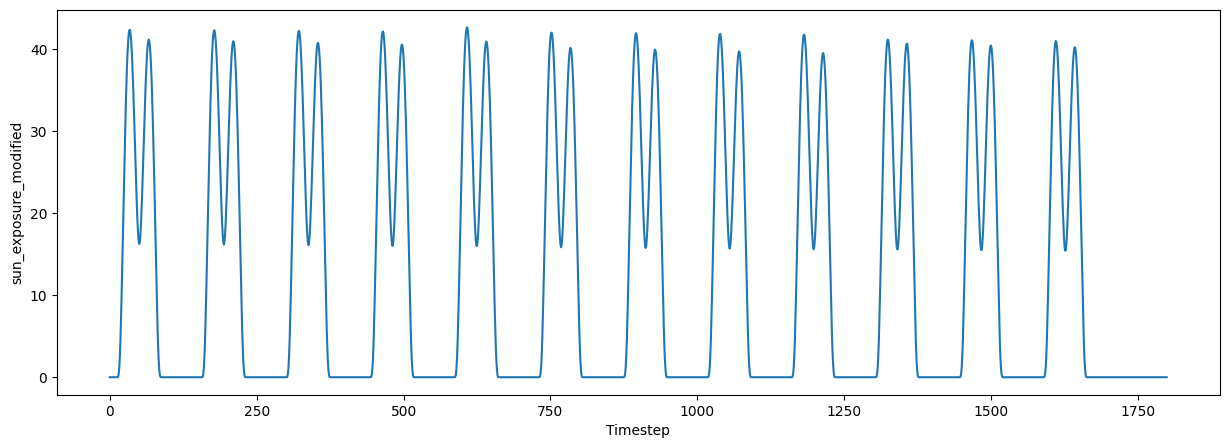

In [189]:
#graph
%matplotlib inline
import matplotlib.pyplot as plt
channel = "sun_exposure_modified"
plt.figure(figsize=(15, 5))
plt.plot(df_last_1800.index,df_last_1800[channel])
plt.xlabel('Timestep')
plt.ylabel(channel)
plt.savefig("../img/buoy_1800.png")

In [190]:
#normalize and park
# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
df_normalized = (df_last_1800 - df_last_1800.min()) / (df_last_1800.max() - df_last_1800.min())

# Create a new DataFrame with an index from 0 to 7199
new_df = pd.DataFrame(index=np.arange(7200))

# Fill the new DataFrame with 0.0 values initially for each column in df_last_1800
for column in df_last_1800.columns:
    new_df[column] = 0.0

# Define the start index to place df_last_1800 at index 0
start_idx = 0
# Place the data from df_last_1800 in the new DataFrame starting at 'start_idx'
new_df.loc[start_idx:start_idx + len(df_normalized) - 1, df_normalized.columns] = df_normalized.values
#again for the tail
start_idx = 5399
new_df.loc[start_idx:start_idx + len(df_normalized) - 1, df_normalized.columns] = df_normalized.values

# Display the resulting DataFrame (showing first and last 10 rows)
new_df.head(10), new_df.tail(10)

(       WDIR      WSPD       GST      WVHT       APD      ATMP      WTMP  \
 0  0.257143  0.636364  0.571429  0.533333  0.369565  0.732143  0.066667   
 1  0.228571  0.636364  0.500000  0.533333  0.369565  0.750000  0.066667   
 2  0.228571  0.636364  0.500000  0.500000  0.358696  0.732143  0.066667   
 3  0.257143  0.636364  0.571429  0.466667  0.347826  0.750000  0.066667   
 4  0.257143  0.727273  0.571429  0.466667  0.347826  0.750000  0.066667   
 5  0.228571  0.636364  0.500000  0.500000  0.347826  0.750000  0.066667   
 6  0.228571  0.636364  0.500000  0.533333  0.347826  0.732143  0.066667   
 7  0.228571  0.636364  0.500000  0.533333  0.347826  0.732143  0.066667   
 8  0.228571  0.636364  0.500000  0.533333  0.358696  0.732143  0.066667   
 9  0.228571  0.636364  0.500000  0.533333  0.369565  0.732143  0.066667   
 
    Timestamp  sun_exposure  sun_exposure_shift  sun_exposure_modified  
 0   0.000000           0.0                 NaN                    0.0  
 1   0.000553   

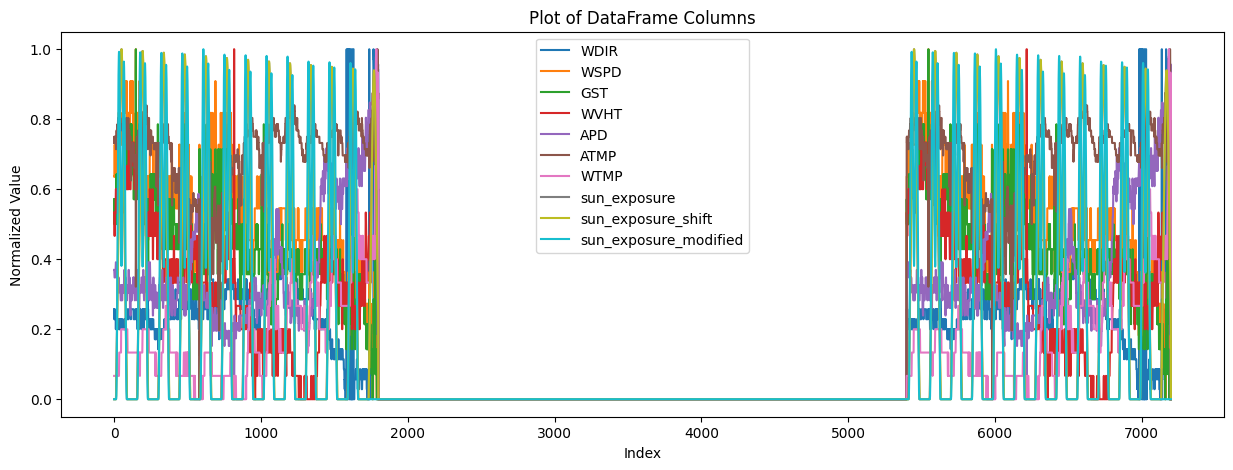

In [191]:
fig, ax = plt.subplots(figsize=(15, 5))

# Loop through each column in the DataFrame
for column_name in new_df.columns:
    if column_name != "Timestamp":# Plot the column directly
        new_df[column_name].plot(label=column_name, ax=ax)

plt.title('Plot of DataFrame Columns')
plt.ylabel('Normalized Value')
plt.xlabel('Index')
plt.legend()
plt.savefig("../img/buoy_7200.png")
plt.show()

In [192]:
new_df.to_csv("../data/buoy_7200.csv", index = True)